# Running the emulator for inference

In this notebook we run a version of the trained emulator in inference mode (`with torch.no_grad()`). We first run the emulator at a single point for a longer time series to judge how it does over long time horizons. Then we look at some global runs over a single independent year of data.

In [1]:
#import ai_land.model as model
import ai_land.model_simple as model
#import ai_land.model_prog as model
import ai_land.data_module as dm
import xarray
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_timeseries(times, targets, predictions, x_idx, state_idx, label, ax):
    """Plots a time series for targets and predictions

    :param times: times on x-axis
    :param targets: ec-land model targets
    :param predictions: emulator predictions
    :param x_idx: spatial index to plot
    :param state_idx: state vector index to plot
    :param label: label for data variables
    :param ax: axes on which to plot the figure
    """
    ax.plot(times, targets[:, x_idx, state_idx].cpu().numpy(), label="ec-land")
    ax.plot(times, predictions[:, x_idx, state_idx].cpu().numpy(), '--', label="ai-land")
    ax.set_title(f"target and prediction for {label}")
    ax.set_xlim([times[0], times[-1]])
    ax.axvline(times[-334*4], color="k", linestyle="--")
    ax.legend()

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
dev

'cuda:0'

In [2]:
# Load a version of the dataclass
dataset = dm.EcDataset()

In [3]:
# Instanciate the Pytorch model
input_clim_dim = dataset.x_static_scaled.shape[-1]
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
output_diag_dim = len(dataset.targ_diag_lst)
hidden_dim = 192  # 172 # 128  # 172  # 128  # 126
model_pyt = model.NonLinearRegression(
    input_clim_dim,
    input_met_dim,
    input_state_dim,
    hidden_dim,
    output_dim,
    output_diag_dim,
    dataset=dataset,
)

In [4]:
len(dataset)

8706

In [5]:
# Open up and load model checkpoint from example training run
# model_pyt.load_state_dict(torch.load("epoch=152-step=153765.ckpt")["state_dict"])
#model_pyt.load_state_dict(torch.load("model.torch", map_location=device)["state_dict"])
model_pyt.load_state_dict(torch.load("/home/daep/projects/ai-land/ai_land/mlruns2/524980797635300527/7695bc3577dd405e8d7a6270e8fa5ec8/checkpoints/epoch=231-step=508312.ckpt", map_location=device)["state_dict"])
model_pyt = model_pyt.to(device)
model_pyt.eval()

NonLinearRegression(
  (fc1): Linear(in_features=42, out_features=192, bias=True)
  (layer_norm1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=192, out_features=192, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=192, out_features=192, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (relu3): ReLU()
  (fc4): Linear(in_features=192, out_features=192, bias=True)
  (relu4): ReLU()
  (layer_norm2): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=192, out_features=7, bias=True)
  (fc6): Linear(in_features=192, out_features=3, bias=True)
)

In [6]:
# Open dataset for point validation
ds_t = dm.EcDataset(
        start_yr=2018,
        end_yr=2022,
        # path="/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6h.zarr",
        # roll_out=1,
        # x_idxs = (9973, 9974)
        path="/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr/",
        roll_out=1,
        x_idxs = (5284, 5285)
    )

print(f"Prognostic targets = {dataset.targ_lst}")
print(f"Diagnostic targets = {dataset.targ_diag_lst}")

Prognostic targets = ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc']
Diagnostic targets = ['d2m', 't2m', 'skt']


In [7]:
# Load data and put it onto device
clim_norm_t, met_norm_t, state_norm_t, state_diag_norm_t = [out_tensor.to(device) for out_tensor in ds_t.load_data()]

In [8]:
%%time
with torch.no_grad():
    # run model
    preds_norm, preds_diag_norm = model_pyt.predict_step(clim_norm_t, met_norm_t, state_norm_t, state_diag_norm_t)
    
    # inverse "z" tranform targets and predictions
    preds = dataset.inv_transform(preds_norm, ds_t.y_prog_means.to(dev), ds_t.y_prog_stdevs.to(dev))
    preds = torch.clip(preds, 0, None)
    preds_diag = dataset.inv_transform(preds_diag_norm, ds_t.y_diag_means.to(dev), ds_t.y_diag_stdevs.to(dev))
    state = dataset.inv_transform(state_norm_t, ds_t.y_prog_means.to(dev), ds_t.y_prog_stdevs.to(dev))
    state_diag = dataset.inv_transform(state_diag_norm_t, ds_t.y_diag_means.to(dev), ds_t.y_diag_stdevs.to(dev))

CPU times: user 3.44 s, sys: 44.1 ms, total: 3.49 s
Wall time: 7.32 s


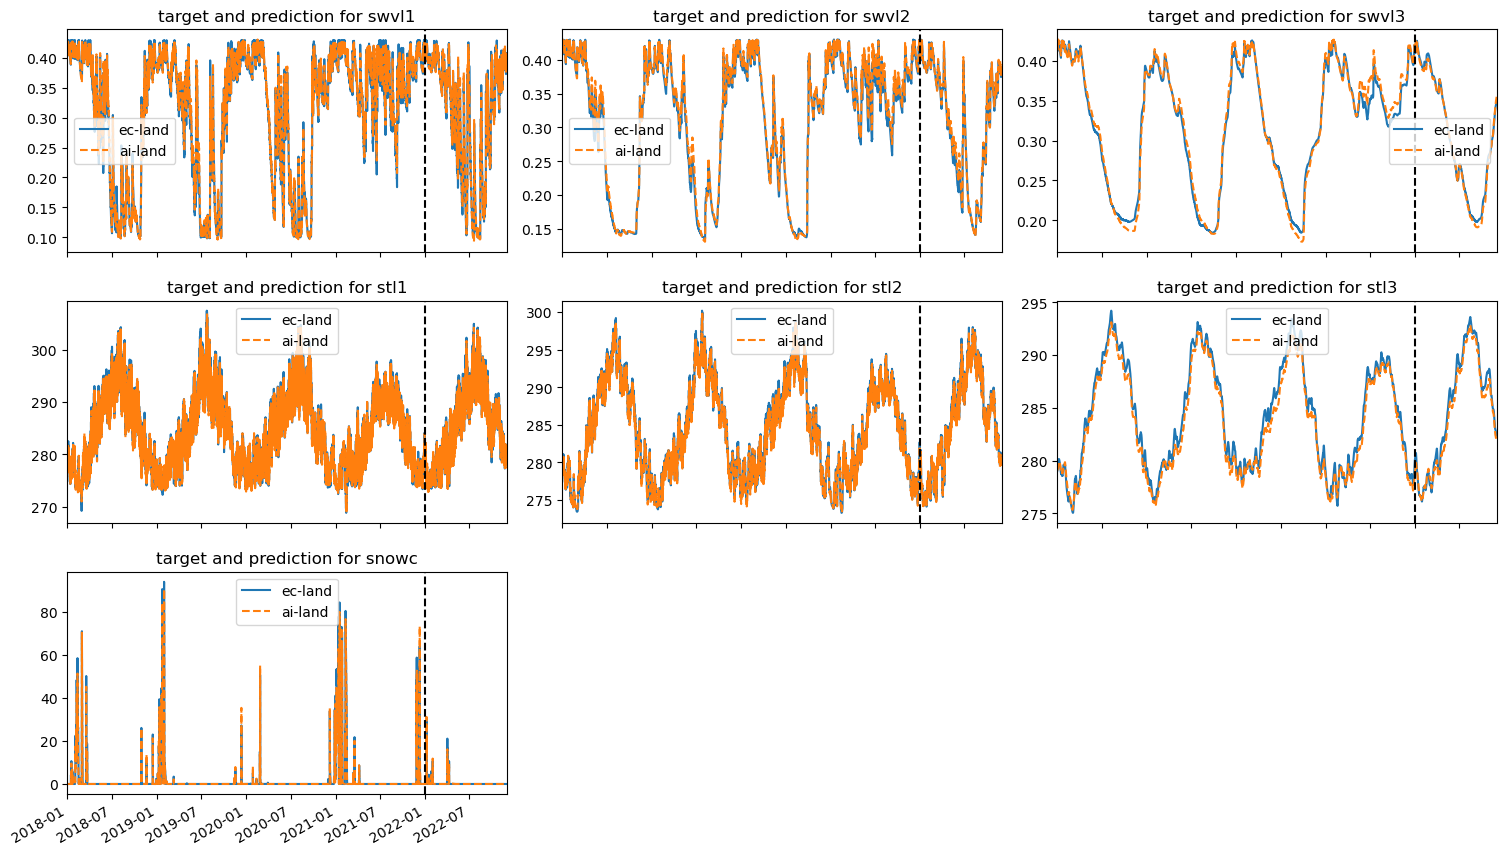

In [9]:
# Plot some timeseries validation for a specific gridcell
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for i, var in enumerate(ds_t.targ_lst):
    axes = ax.flatten()[i]
    plot_timeseries(ds_t.times, state, preds, 0, i, var, axes)
    
ax.flatten()[-2].remove()
ax.flatten()[-1].remove()
fig.tight_layout()
fig.autofmt_xdate()

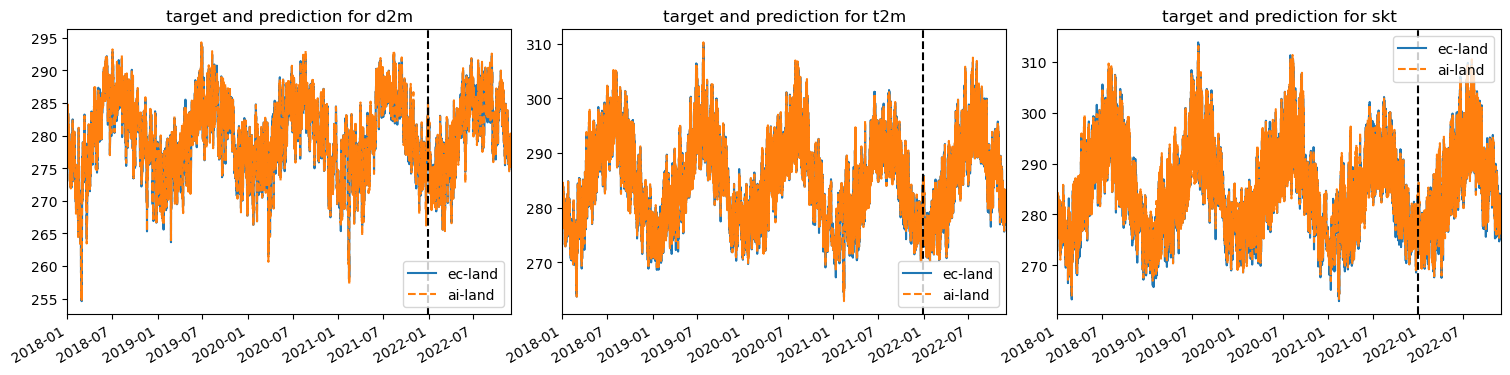

In [10]:
# Plot diagnostic outputs for specific gridcell
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, var in enumerate(ds_t.targ_diag_lst):
    axes = ax.flatten()[i]
    plot_timeseries(ds_t.times, state_diag, preds_diag, 0, i, var, axes)

fig.tight_layout()
fig.autofmt_xdate()

In [11]:
# Open dataset for global 1-year run and run model
dataset = dm.EcDataset(
        start_yr=2022,
        end_yr=2022,
        path="/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6h.zarr",
        roll_out=1,
    )

print(f"Prognostic targets = {dataset.targ_lst}")
print(f"Diagnostic targets = {dataset.targ_diag_lst}")

clim_norm, met_norm, state_norm, state_diag_norm = [out_tensor.to(device) for out_tensor in dataset.load_data()]

with torch.no_grad():
    # run model
    preds_norm, preds_diag_norm = model_pyt.predict_step(clim_norm, met_norm, state_norm, state_diag_norm)
    
    # inverse "z" tranform targets and predictions
    preds = dataset.inv_transform(preds_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    preds = torch.clip(preds, 0, None)
    preds_diag = dataset.inv_transform(preds_diag_norm, dataset.y_diag_means.to(dev), dataset.y_diag_stdevs.to(dev))
    state = dataset.inv_transform(state_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    state_diag = dataset.inv_transform(state_diag_norm, dataset.y_diag_means.to(dev), dataset.y_diag_stdevs.to(dev))

Prognostic targets = ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc']
Diagnostic targets = ['d2m', 't2m', 'skt']


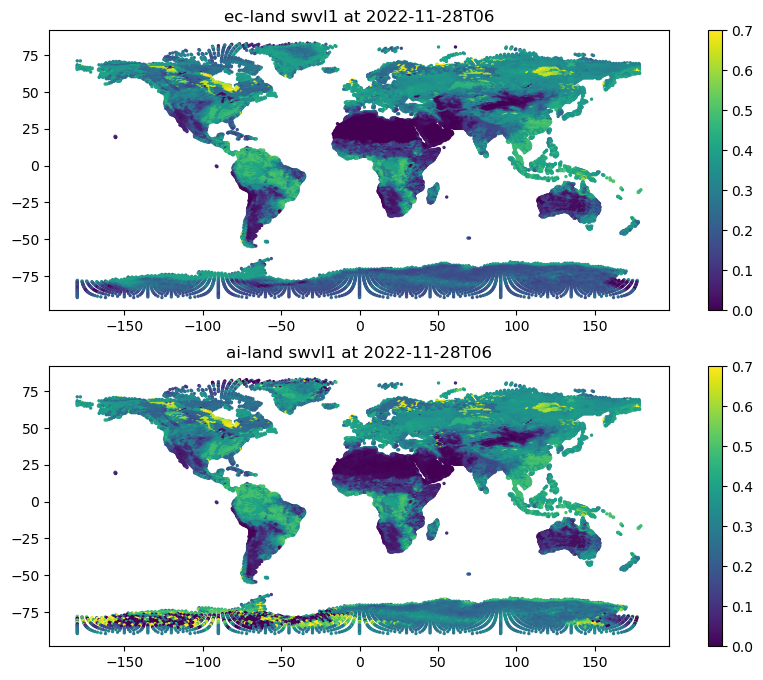

In [12]:
state_idx = 0
t_idx = -10

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.7, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.7, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

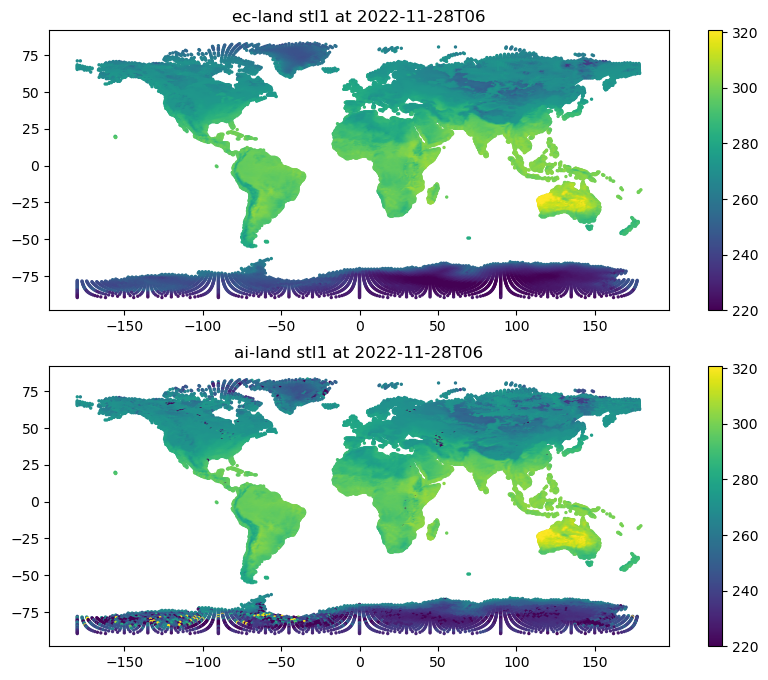

In [13]:
state_idx = 3
t_idx = -10

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=220, vmax=320.7, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=220, vmax=320.7, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

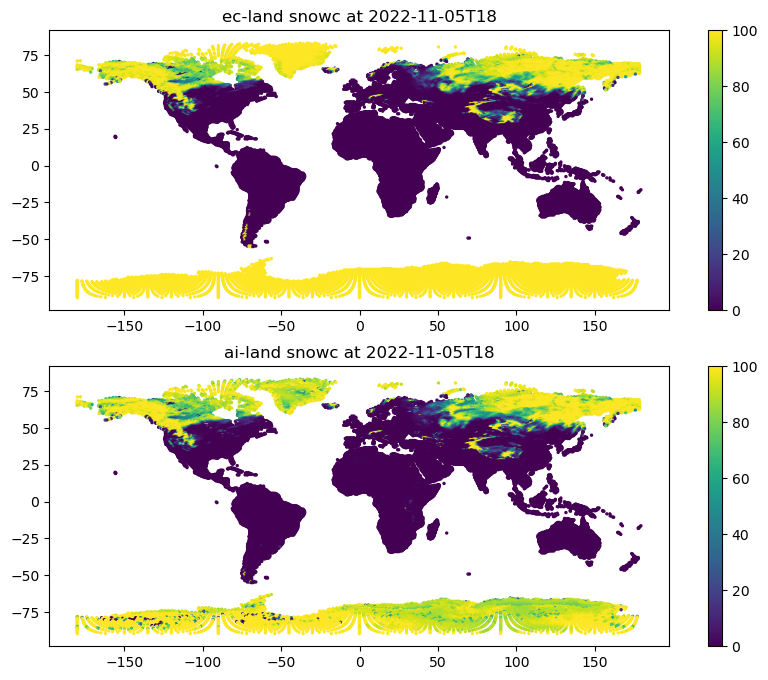

In [14]:
state_idx = 6
t_idx = -100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=100, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=100, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)